<a href="https://colab.research.google.com/github/NeelayS/speech_spike_signatures/blob/master/STDP_PyGeNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/genn-team/genn.git --branch 4.1.0

Cloning into 'genn'...
remote: Enumerating objects: 3116, done.
remote: Counting objects: 100% (3116/3116), done.
remote: Compressing objects: 100% (1611/1611), done.
remote: Total 79777 (delta 2004), reused 2220 (delta 1436), pack-reused 76661
Receiving objects: 100% (79777/79777), 223.71 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (55769/55769), done.
Note: checking out '37e7a83b1c2c5cfa158e46f4290acb24a58d6e7f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [3]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (10.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (

In [4]:
import os
os.environ['CUDA_PATH'] ='/usr/local/cuda'

In [5]:
os.chdir('genn/')
!make DYNAMIC=1 LIBRARY_DIRECTORY=`pwd`/pygenn/genn_wrapper/

make -C src/genn/genn
make[1]: Entering directory '/content/genn/src/genn/genn'
mkdir -p /content/genn/obj_dynamic/genn/genn
g++ -std=c++11 -Wall -Wpedantic -Wextra -MMD -MP -I/content/genn/include/genn/genn -I/content/genn/include/genn/third_party -fPIC -c -o /content/genn/obj_dynamic/genn/genn/synapseGroup.o synapseGroup.cc
mkdir -p /content/genn/obj_dynamic/genn/genn
g++ -std=c++11 -Wall -Wpedantic -Wextra -MMD -MP -I/content/genn/include/genn/genn -I/content/genn/include/genn/third_party -fPIC -c -o /content/genn/obj_dynamic/genn/genn/neuronModels.o neuronModels.cc
mkdir -p /content/genn/obj_dynamic/genn/genn
g++ -std=c++11 -Wall -Wpedantic -Wextra -MMD -MP -I/content/genn/include/genn/genn -I/content/genn/include/genn/third_party -fPIC -c -o /content/genn/obj_dynamic/genn/genn/initVarSnippet.o initVarSnippet.cc
mkdir -p /content/genn/obj_dynamic/genn/genn
g++ -std=c++11 -Wall -Wpedantic -Wextra -MMD -MP -I/content/genn/include/genn/genn -I/content/genn/include/genn/third_party -fP

In [6]:
!python setup.py develop

running develop
running egg_info
creating pygenn.egg-info
writing pygenn.egg-info/PKG-INFO
writing dependency_links to pygenn.egg-info/dependency_links.txt
writing requirements to pygenn.egg-info/requires.txt
writing top-level names to pygenn.egg-info/top_level.txt
writing manifest file 'pygenn.egg-info/SOURCES.txt'
writing manifest file 'pygenn.egg-info/SOURCES.txt'
running build_ext
building '_StlContainers' extension
swigging pygenn/genn_wrapper/generated/StlContainers.i to pygenn/genn_wrapper/generated/StlContainers_wrap.cpp
swig -python -c++ -relativeimport -outdir /content/genn/pygenn/genn_wrapper -I/content/genn/pygenn/genn_wrapper/include -I/content/genn/pygenn/genn_wrapper/generated -I/content/genn/pygenn/genn_wrapper/swig -py3 -o pygenn/genn_wrapper/generated/StlContainers_wrap.cpp pygenn/genn_wrapper/generated/StlContainers.i
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pygenn
creating build/temp.linux-x86_64-3.6/pygenn/genn_wrappe

# IMPORTS

In [7]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [8]:
from pygenn import genn_model, genn_wrapper 
from pygenn.genn_model import (create_custom_neuron_class,
                               create_custom_current_source_class,
                               GeNNModel)

# Hebbian STDP

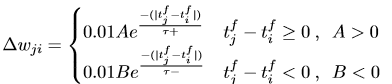

To obtain anti-Hebbian STDP, we swap the cases

### Hebbian STDP

In [9]:
# STDP_Hebbian_Model

# sim_code is called when a presynaptic spike occurs, after $(addToInSyn, $(g)) is called,
# i.e. where dt = $(t) - $(sT_post)

# learn_post_code is called when a postsynaptic spike occurs so should only be handling the postsynaptic after presynaptic spike case
# dt is calculated (which will always be positive) with dt = $(t) - $(sT_pre)

# The max value of a weight is gMax, similarly gMin is minimum

stdp_model = genn_model.create_custom_weight_update_class(
    "stdp_model_Hebbian",                                                      
    param_names=["tauMinus", "tauPlus", "A", "B","gMax","gMin"],       # defining parameters which will remain common throughout
    var_name_types=[("g", "scalar")],                                  # state variables to track each synaptic connection
    sim_code=
        """
        $(addToInSyn, $(g));
        scalar dt = $(t) - $(sT_post);                                
        if (dt > 0) {
          scalar timing = exp(-dt / $(tauMinus));
          scalar newWeight = $(g) - ($(B) * timing);
          $(g) = fmax($(gMin), newWeight);                             
        }
        """,
    learn_post_code=
        """
        scalar dt = $(t) - $(sT_pre);
        if(dt > 0) {
            scalar timing = exp(-dt / $(tauPlus));
            scalar newWeight = $(g) + ($(A) * timing);
            $(g) = fmin($(gMax), newWeight);
        }
        """,

    is_pre_spike_time_required=True,
    is_post_spike_time_required=True
)

### Anti-hebbian STDP

In [10]:
#  STDP_Anti_Hebbian_Model

# sim_code is called when a presynaptic spike occurs, after $(addToInSyn, $(g)) is called,
# i.e. where dt = $(t) - $(sT_post)

# learn_post_code is called when a postsynaptic spike occurs so should only be handling the postsynaptic after presynaptic spike case
# dt is calculated (which will always be positive) with dt = $(t) - $(sT_pre)

# The max value of a weight is gMax, similarly gMin is minimum

stdp_model_anti_Hebbian = genn_model.create_custom_weight_update_class(
    "stdp_model_anti_Hebbian",
    param_names=["tauMinus", "tauPlus", "A", "B","gMax","gMin"],
    var_name_types=[("g", "scalar")],
    sim_code=
        """
        $(addToInSyn, $(g));
        scalar dt = $(t) - $(sT_post);
        if(dt > 0) {
          scalar timing = exp(-dt / $(tauPlus));
          scalar newWeight = $(g) + ($(A) * timing);
          $(g) = fmin($(gMax), newWeight);
        }
        """,
    learn_post_code=
        """
        scalar dt = $(t) - $(sT_pre);
        if (dt > 0) {
          scalar timing = exp(-dt / $(tauMinus));
          scalar newWeight = $(g) - ($(B) * timing);
          $(g) = fmax($(gMin), newWeight);
        }
        """,

    is_pre_spike_time_required=True,
    is_post_spike_time_required=True
)

In [11]:

# ********************************************************************************
#                      Parameters and Hyperparameters
# ********************************************************************************

# Hyperparameters

timestep = 0.1


# Neuron layer sizes
n_pop_i = 784
n_pop_o = 10

# Parameters and initial values
izk_init = {"V": -60.0,
            "U": -20.0,
            "a": 0.02,
            "b": 0.2,
            "c": -65.0,
            "d": 8.0}


stdp_init = {"g":genn_model.init_var("Uniform",{"min":0.1, "max":1.0})}

stdp_params = {"tauMinus": 20.0, "tauPlus": 20.0, "A":0.1, "B":0.1, "gMax": 1.0, "gMin":0.1}


In [12]:
#Create new network using single precision and generating code in STDP Hebbian
model = genn_model.GeNNModel("float","stdp_hebbian")



izk_pop_pre = model.add_neuron_population("izk_pop_pre", n_pop_i, "IzhikevichVariable", {}, izk_init)
izk_pop_post = model.add_neuron_population("izk_pop_post", n_pop_o, "IzhikevichVariable", {}, izk_init)

neuron_layers = [izk_pop_pre,izk_pop_post]

syn_io_pop = model.add_synapse_population("syn_io_pop","DENSE_INDIVIDUALG",genn_wrapper.NO_DELAY,
    izk_pop_pre,izk_pop_post,stdp_model,stdp_params,stdp_init,{},{},
        "DeltaCurr", {}, {})


# Download and Process Data

In [13]:
!ls

bin			     include	  publishdoc	   setup.py
build			     Jenkinsfile  __pycache__	   spineml.sln
codecov.yml		     lib	  py_filter.sh	   src
CODE_OF_CONDUCT.md	     LICENSE.txt  pygenn	   tests
doxygen			     makedoc.sh   pygenn.egg-info  userproject
generate_swig_interfaces.py  Makefile	  README.md	   version.txt
genn.sln		     obj_dynamic  README.txt	   www


In [14]:
%cd ..

/content


In [15]:
!wget https://zenodo.org/record/1342401/files/Jakobovski/free-spoken-digit-dataset-v1.0.8.zip

--2020-09-25 10:18:11--  https://zenodo.org/record/1342401/files/Jakobovski/free-spoken-digit-dataset-v1.0.8.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7273063 (6.9M) [application/octet-stream]
Saving to: ‘free-spoken-digit-dataset-v1.0.8.zip’

free-spoken-digit-d 100%[===================>]   6.94M  38.0MB/s    in 0.2s    

2020-09-25 10:18:12 (38.0 MB/s) - ‘free-spoken-digit-dataset-v1.0.8.zip’ saved [7273063/7273063]



In [16]:
!unzip free-spoken-digit-dataset-v1.0.8.zip

Archive:  free-spoken-digit-dataset-v1.0.8.zip
e9e1155aba3a0c632823b813aa74918807644509
   creating: Jakobovski-free-spoken-digit-dataset-e9e1155/
 extracting: Jakobovski-free-spoken-digit-dataset-e9e1155/.gitignore  
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/README.md  
 extracting: Jakobovski-free-spoken-digit-dataset-e9e1155/__init__.py  
   creating: Jakobovski-free-spoken-digit-dataset-e9e1155/acquire_data/
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/acquire_data/say_numbers_prompt.py  
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/acquire_data/split_and_label_numbers.py  
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/metadata.py  
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/pip_requirements.txt  
   creating: Jakobovski-free-spoken-digit-dataset-e9e1155/recordings/
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/recordings/0_jackson_0.wav  
  inflating: Jakobovski-free-spoken-digit-dataset-e9e1155/recor

In [17]:

import matplotlib.pyplot as plt
import librosa
from librosa import display
import os
import scipy
import numpy as np


In [18]:
!ls

free-spoken-digit-dataset-v1.0.8.zip
genn
Jakobovski-free-spoken-digit-dataset-e9e1155
sample_data


In [21]:
!mv Jakobovski-free-spoken-digit-dataset-e9e1155 FSDD

In [19]:
data_root = 'FSDD/recordings'

In [22]:
samples, sampling_rate = librosa.load(os.path.join(data_root, '0_jackson_0.wav'), sr=None, mono=True, offset=0.0, duration=None)
len(samples), sampling_rate, len(samples)/sampling_rate

(5148, 8000, 0.6435)

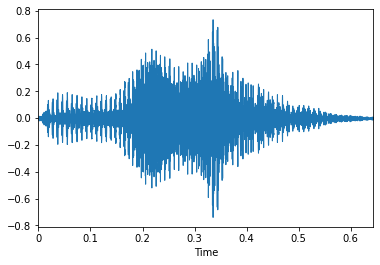

In [23]:
plt.figure()
display.waveplot(y=samples, sr=sampling_rate)
plt.show()

In [24]:
class Dataset:
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        
    def _frame(self, samples, sample_rate, window_ms):
        stride_ms= window_ms/2;
        stride_size = int(0.001 * sample_rate * stride_ms)
        window_size = int(0.001 * sample_rate * window_ms)

        # Extract strided windows
        truncate_size = (len(samples) - window_size) % stride_size
        samples = samples[:len(samples) - truncate_size]
        nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
        nstrides = (samples.strides[0], samples.strides[0] * stride_size)
        windows = np.lib.stride_tricks.as_strided(samples, 
                                              shape = nshape, strides = nstrides)

        assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

        # Window weighting, squared Fast Fourier Transform (fft), scaling
        weighting = np.hanning(window_size)[:, None]

        fft = np.fft.fft(windows * weighting, axis=0)
        fft = np.absolute(fft)
        fft = fft**2
        scale = np.sum(weighting**2) * sample_rate
        fft[1:-1, :] *= (2.0 / scale)
        fft[(0, -1), :] /= scale
        fft= np.log(fft)

        # Prepare fft frequency list
        freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])


        frames=[]
        for i in range(40):
            bands=[]
            band0=[]
            band1=[]
            band2=[]
            band3=[]
            band4=[]
            j=0
            for freq in freqs:
                if freq <= 333.3:
                    band0.append(fft[j][i])
                elif freq > 333.3 and freq <= 666.7:
                    band1.append(fft[j][i])
                elif freq > 666.7 and freq <= 1333.3:
                    band2.append(fft[j][i])
                elif freq > 1333.3 and freq <= 2333.3:
                    band3.append(fft[j][i])
                elif freq > 2333.3 and freq <= 4000:
                    band4.append(fft[j][i])

                j += 1
            bands.append(np.sum(band0)/ np.shape(band0)[0])
            bands.append(np.sum(band1)/ np.shape(band1)[0])
            bands.append(np.sum(band2)/ np.shape(band2)[0])
            bands.append(np.sum(band3)/ np.shape(band3)[0])
            bands.append(np.sum(band4)/ np.shape(band4)[0])
            frames.append(bands)
        
        return frames
    
    def preprocess(self):
        N=40
        overlap=0.5
        for file in os.listdir(self.root_dir):
            samples, sampling_rate = librosa.load(os.path.join(data_root, file), sr=None, mono=True, offset=0.0, duration=None)
            window_size= ((len(samples)*1000)/sampling_rate)/(N*(1-overlap) + overlap)
            self.data.append(self._frame(samples, sampling_rate, window_size))

In [25]:
dataset = Dataset(data_root)
dataset.preprocess()
print(np.shape(dataset.data))

(1500, 40, 5)


In [47]:
features = dataset.data[0]
features

[[-16.88119125463792,
  -17.944066016927152,
  -18.87586686325766,
  -18.379871348689313,
  -17.32954711610107],
 [-18.45727369869065,
  -19.00461728503551,
  -19.698964001408683,
  -18.016952986494637,
  -17.824363939934848],
 [-17.75185653390904,
  -19.289253383449328,
  -19.53086416048638,
  -18.25466170136659,
  -18.271585817692863],
 [-17.577249507294276,
  -18.75820324156208,
  -20.248250374378024,
  -17.718352211411972,
  -18.192163596715442],
 [-17.528767224316987,
  -18.7980162250458,
  -19.59694478754143,
  -19.003606681727366,
  -17.88089518555581],
 [-17.81258282182112,
  -16.472175284783017,
  -19.785580969084776,
  -18.70084277462185,
  -18.801338510553467],
 [-17.401650686364178,
  -19.285439379950645,
  -20.28094087765241,
  -18.5390363223738,
  -19.370357695191494],
 [-18.408098412479372,
  -18.73666546665665,
  -19.860016701012235,
  -18.081151748469757,
  -19.055637468529817],
 [-17.348117544724353,
  -18.450993216692307,
  -19.576662717360218,
  -18.882801191528973,

In [52]:
max(np.array(features).flatten()), min(np.array(features).flatten())

(-12.084434701893532, -20.999052496723348)